# Twitter Bot Detector

## Install Dependencies

In [0]:
!sudo pip install --upgrade pip
!sudo pip install pyspark --upgrade
#!pip install -U -q PyDrive
#!pip install --upgrade google-api-python-client
!pip install mlflow

Requirement already satisfied: pip in /usr/local/lib/python3.8/site-packages (21.1.1)
 WARNING: Running pip as root will break packages and permissions. You should install packages reliably by using venv: https://pip.pypa.io/warnings/venv 
Requirement already satisfied: pyspark in /usr/local/lib/python3.8/site-packages (3.1.1)
Requirement already satisfied: py4j==0.10.9 in /usr/local/lib/python3.8/site-packages (from pyspark) (0.10.9)
 WARNING: Running pip as root will break packages and permissions. You should install packages reliably by using venv: https://pip.pypa.io/warnings/venv 
Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.17.0)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.0)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.16)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Requirement already satisfied: alembic<=1.4.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.1)
Requirement already satisfied: pyyaml in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.4.1)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.0.0)
Requirement already satisfied: prometheus-flask-exporter in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.18.2)
Requirement already satisfied: docker>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.0.0)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.0)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: protobuf>=3.6.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.0)
Requirement already satisfied: querystring-parser in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.1)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.1.3)
Requirement already satisfied: gunicorn; platform_system != "Windows" in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.1.0)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.24.0)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.14.3)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: sqlalchemy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.15)
Requirement already satisfied: itsdangerous>=2.0 in /databricks/python3/lib/python3.8/site-packages (from Flask->mlflow) (2.0.0)
Requirement already satisfied: Jinja2>=3.0 in /databricks/python3/lib/python3.8/site-packages (from Flask->mlflow) (3.0.0)
Requirement already satisfied: Werkzeug>=2.0 in /databricks/python3/lib/python3.8/site-packages (from Flask->mlflow) (2.0.0)
Requirement already satisfied: gitdb<5,>=4.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitpython>=2.1.0->mlflow) (4.0.7)
Requirement already satisfied: Mako in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (1.1.4)
Requirement already satisfied: python-dateutil in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (2.8.1)
Requirement already satisfied: python-editor>=0.3 in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (1.0.4)
Requirement already satisfied: prometheus-client in /databricks/python3/lib/python3.8/site-packages (

## Import Python Packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.session import SparkSession
from pyspark import SparkContext, SparkConf, SparkFiles


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer

import datetime
now = datetime.datetime.now()

## Check everything is ok

In [0]:
spark
sc._conf.getAll()

Out[5]: [('spark.files.useFetchCache', 'false'),
 ('spark.databricks.preemption.enabled', 'true'),
 ('spark.driver.tempDirectory', '/local_disk0/tmp'),
 ('spark.hadoop.fs.adl.impl.disable.cache', 'true'),
 ('spark.hadoop.parquet.block.size.row.check.max', '10'),
 ('spark.hadoop.fs.s3a.connection.maximum', '200'),
 ('spark.databricks.clusterUsageTags.numPerClusterInitScriptsV2', '0'),
 ('spark.executor.extraJavaOptions',
 '-Djava.io.tmpdir=/local_disk0/tmp -XX:ReservedCodeCacheSize=512m -XX:+UseCodeCacheFlushing -Djava.security.properties=/databricks/spark/dbconf/java/extra.security -XX:-UseContainerSupport -XX:+PrintFlagsFinal -XX:+PrintGCDateStamps -verbose:gc -XX:+PrintGCDetails -Xss4m -Djava.library.path=/usr/java/packages/lib/amd64:/usr/lib64:/lib64:/lib:/usr/lib:/usr/lib/x86_64-linux-gnu/jni:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/usr/lib/jni -Djavax.xml.datatype.DatatypeFactory=com.sun.org.apache.xerces.internal.jaxp.datatype.DatatypeFactoryImpl -Djavax.xml.parsers.DocumentBuilderFactory=com.sun.org.apache.xerces.internal.jaxp.DocumentBuilderFactoryImpl -Djavax.xml.parsers.SAXParserFactory=com.sun.org.apache.xerces.internal.jaxp.SAXParserFactoryImpl -Djavax.xml.validation.SchemaFactory:http://www.w3.org/2001/XMLSchema=com.sun.org.apache.xerces.internal.jaxp.validation.XMLSchemaFactory -Dorg.xml.sax.driver=com.sun.org.apache.xerces.internal.parsers.SAXParser -Dorg.w3c.dom.DOMImplementationSourceList=com.sun.org.apache.xerces.internal.dom.DOMXSImplementationSourceImpl -Djavax.net.ssl.sessionCacheSize=10000 -Dscala.reflect.runtime.disable.typetag.cache=true -Ddatabricks.serviceName=spark-executor-1'),
 ('spark.databricks.sparkContextId', '4811538902969247468'),
 ('spark.hadoop.fs.s3a.fast.upload.active.blocks', '32'),
 ('spark.shuffle.reduceLocality.enabled', 'false'),
 ('spark.sql.streaming.checkpointFileManagerClass',
 'com.databricks.spark.sql.streaming.DatabricksCheckpointFileManager'),
 ('spark.databricks.service.dbutils.repl.backend',
 'com.databricks.dbconnect.ReplDBUtils'),
 ('spark.databricks.clusterUsageTags.driverNodeType', 'dev-tier-node'),
 ('spark.hadoop.spark.sql.sources.outputCommitterClass',
 'com.databricks.backend.daemon.data.client.MapReduceDirectOutputCommitter'),
 ('spark.driver.host', '10.172.224.56'),
 ('spark.databricks.clusterUsageTags.instanceBootstrapType', 'ssh'),
 ('spark.streaming.driver.writeAheadLog.allowBatching', 'true'),
 ('spark.databricks.clusterSource', 'UI'),
 ('spark.hadoop.fs.AbstractFileSystem.gs.impl',
 'shaded.databricks.V2_1_4.com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS'),
 ('spark.hadoop.hive.server2.transport.mode', 'http'),
 ('spark.hadoop.hive.server2.thrift.http.cookie.auth.enabled', 'false'),
 ('spark.executor.memory', '8278m'),
 ('spark.databricks.driverNodeTypeId', 'dev-tier-node'),
 ('spark.sql.parquet.compression.codec', 'snappy'),
 ('spark.hadoop.fs.cpfs-adl.impl.disable.cache', 'true'),
 ('spark.databricks.clusterUsageTags.hailEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.clusterLogDeliveryEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.containerType', 'LXC'),
 ('spark.eventLog.enabled', 'false'),
 ('spark.databricks.clusterUsageTags.isIMv2Enabled', 'false'),
 ('spark.databricks.cloudfetch.hasRegionSupport', 'true'),
 ('spark.hadoop.databricks.s3.create.deleteUnnecessaryFakeDirectories',
 'false'),
 ('spark.hadoop.fs.wasb.impl',
 'shaded.databricks.org.apache.hadoop.fs.azure.NativeAzureFileSystem'),
 ('spark.repl.class.outputDir',
 '/local_disk0/tmp/repl/spark-4811538902969247468-6a3f739c-886c-4ab8-9634-742a431e7928'),
 ('spark.executor.tempDirectory', '/local_disk0/tmp'),
 ('spark.databricks.workerNodeTypeId', 'dev-tier-node'),
 ('spark.hadoop.mapred.output.committer.class',
 'com.databricks.backend.daemon.data.client.DirectOutputCommitter'),
 ('spark.hadoop.hive.server2.thrift.http.port', '10000'),
 ('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version', '2'),
 ('spark.sql.allowMultipleContexts', 'false'),
 ('spark.databricks

## Upload Dataset

In [0]:
bot_df = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/tavoulari.1977701@studenti.uniroma1.it/twitter_human_bots_dataset_clean-2.csv", header='true')

## Convert numbers stored as text to numbers

In [0]:
temp_df = bot_df
"""
bot_df = bot_df.withColumn("geo_enabled", when(bot_df.geo_enabled == "False",0) \
                           .when(bot_df.geo_enabled == "True",1))
bot_df = bot_df.withColumn("verified", when(bot_df.verified == "False",0) \
                           .when(bot_df.verified == "True",1))
bot_df = bot_df.withColumn("has_extended_profile", when(bot_df.has_extended_profile == "False",0) \
                           .when(bot_df.has_extended_profile == "True",1))
bot_df = bot_df.withColumn("default_profile", when(bot_df.default_profile == "False",0) \
                           .when(bot_df.default_profile == "True",1))
bot_df = bot_df.withColumn("default_profile_image", when(bot_df.default_profile_image == "False",0) \
                           .when(bot_df.default_profile_image == "True",1))
bot_df = bot_df.withColumn("account_type", when(bot_df.account_type == "human",0) \
                           .when(bot_df.account_type == "bot",1))
"""
# Subtract profiles' creation dates from current date
def to_days(then):
  now = datetime.datetime.now()
  date_time_obj = datetime.datetime.strptime(then, '%Y-%m-%d %H:%M:%S').date()
  diff =(now.date() - date_time_obj)
  diff = str(diff).split(' ')
  return int(diff[0])

to_days_UDF = spark.udf.register("to_days",to_days)
bot_df = bot_df.withColumn("created_at", to_days_UDF(col("created_at")))

bot_df = bot_df.selectExpr("account_type","cast(follower_count as int) follower_count","cast(friends_count as int) friends_count","cast(listed_count as int) listed_count","cast(statuses_count as int) statuses_count","cast(retweets as float) retweets","cast(with_url as float) with_url","cast(with_mention as float) with_mention","geo_enabled", "verified", "has_extended_profile", "default_profile", "default_profile_image","cast(created_at as int) created_at")

bot_df_text = temp_df.selectExpr("screen_name", "description", "tweet_text")
bot_df.printSchema()
bot_df.show(5)


root
-- account_type: string (nullable = true)
-- follower_count: integer (nullable = true)
-- friends_count: integer (nullable = true)
-- listed_count: integer (nullable = true)
-- statuses_count: integer (nullable = true)
-- retweets: float (nullable = true)
-- with_url: float (nullable = true)
-- with_mention: float (nullable = true)
-- geo_enabled: string (nullable = true)
-- verified: string (nullable = true)
-- has_extended_profile: string (nullable = true)
-- default_profile: string (nullable = true)
-- default_profile_image: string (nullable = true)
-- created_at: integer (nullable = true)

+------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+
account_type|follower_count|friends_count|listed_count|statuses_count| retweets| with_url|with_mention|geo_enabled|verified|has_extended_profile|default_profile|default_profile_image|created_at|
+------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+
 bot| 1701| 4| 53| 13123| 0.0| 0.0| 0.0| False| False| False| False| False| 1671|
 human| 823| 852| 5| 251|0.34108528| 0.33333334| 0.4031008| False| False| True| False| False| 1646|
 human| 193| 807| 2| 1204|0.15384616| 0.23846154| 0.3| True| False| False| False| False| 1426|
 human| 569| 659| 2| 1651|0.63076925|0.092307694| 0.9692308| True| False| False| True| False| 1757|
 human| 748287| 118| 1817| 4292|0.23255815| 0.20930232| 0.8062016| True| True| False| False| False| 3406|
+------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+
only showing top 5 rows

## Split features into categories

In [0]:
# Let's define some constants which we will use throughout this notebook
NUMERICAL_FEATURES = ["follower_count", 
                      "friends_count",
                      "listed_count",
                      "statuses_count",
                      "retweets",
                      "with_url",
                      "with_mention",
                      "created_at"
                      ]
CATEGORICAL_FEATURES = ["geo_enabled", 
                        "verified", 
                        "has_extended_profile",
                        "default_profile",
                        "default_profile_image",
                        ]

TEXTUAL_FEATURES =  ["screen_name",
                     "description",
                     "tweet_text"
                     ]

TARGET_VARIABLE = "account_type"

In [0]:
RANDOM_SEED = 42 # for reproducibility
bot_df.groupBy(TARGET_VARIABLE).count().show()
train_df, test_df = bot_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

+------------+-----+
account_type|count|
+------------+-----+
 human|18935|
 bot| 5260|
+------------+-----+

## Vectorize features

In [0]:
# This function is responsible to implement the pipeline above for transforming categorical features into numerical ones
def to_numerical(df, numerical_features, categorical_features, target_variable):

    """
    Args:
        - df: the input dataframe
        - numerical_features: the list of column names in `df` corresponding to numerical features
        - categorical_features: the list of column names in `df` corresponding to categorical features
        - target_variable: the column name in `df` corresponding to the target variable

    Return:
        - transformer: the pipeline of transformation fit to `df` (for future usage)
        - df_transformed: the dataframe transformed according to the pipeline
    """
    

    # 1. Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # 2. Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 3. Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 4. Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    # 5. Populate the stages of the pipeline
    stages = indexers + [encoder] + [label_indexer] + [assembler]

    # 6. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=stages)

    # 7. Transform the input dataframe accordingly
    transformer = pipeline.fit(df)
    df_transformed = transformer.transform(df)

    # 8. Eventually, return both the transformed dataframe and the transformer object for future transformations
    return transformer, df_transformed

In [0]:
# Transform the training set and get back both the transformer and the new dataset
oh_transformer, oh_train_df = to_numerical(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

In [0]:
oh_train_df.show(1000, truncate=False)

+------------+--------------+-------------+------------+--------------+------------+------------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-------------------+----------------+----------------------------+-----------------------+-----------------------------+------------------------------------+-------------------------------+-------------------------------------+------------------------+---------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+
account_type|follower_count|friends_count|listed_count|statuses_count|retweets |with_url |with_mention|geo_enabled|verified|has_extended_profile|default_profile|default_profile_image|created_at|geo_enabled_indexed|verified_indexed|has_extended_profile_indexed|default_profile_indexed|default_profile_image_indexed|has_extended_profile_indexed_encoded|default_profile_indexed_encoded|default_profile_image_indexed_encoded|verified_indexed_encoded|geo_enabled_indexed_encoded|label|features |
+------------+--------------+-------------+------------+--------------+------------+------------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-------------------+----------------+----------------------------+-----------------------+-----------------------------+------------------------------------+-------------------------------+-------------------------------------+------------------------+---------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+
bot |0 |0 |0 |18 |0.7222222 |0.22222222 |0.6666667 |False |False |False |True |False |3087 |1.0 |0.0 |0.0 |1.0 |0.0 |(3,[0],[1.0]) |(3,[1],[1.0]) |(3,[0],[1.0]) |(3,[0],[1.0]) |(3,[1],[1.0]) |1.0 |(23,[1,3,6,10,12,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,18.0,0.7222222089767456,0.2222222238779068,0.6666666865348816,3087.0]) |
bot |0 |0 |0 |34 |0.8064516 |0.38709676 |0.7741935 |False |False |False |True |True |3692 |1.0 |0.0 |0.0 |1.0 |1.0 |(3,[0],[1.0]) |(3,[1],[1.0]) |(3,[1],[1.0]) |(3,[0],[1.0]) |(3,[1],[1.0]) |1.0 |(23,[1,3,6,10,13,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,34.0,0.8064516186714172,0.3870967626571655,0.774193525314331,3692.0]) |
bot |0 |0 |1 |224 |0.9655172 |0.57758623 |0.9396552 |False |False |False |True |False |1409 |1.0 |0.0 |0.0 |1.0 |0.0 |(3,[0],[1.0]) |(3,[1],[1.0]) |(3,[0],[1.0]) |(3,[0],[1.0]) |(3,[1],[1.0]) |1.0 |(23,[1,3,6,10,12,17,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,224.0,0.9655172228813171,0.5775862336158752,0.9396551847457886,1409.0]) |
bot |0 |2 |0 |59 |0.0 |1.0 |1.0 |False |False |False |True |True |872 |1.0 |0.0 |0.0 |1.0 |1.0 |(3,[0],[1.0]) |(3,[1],[1.0]) |(3,[1],[1.0]) |(3,[0],[1.0]) |(3,[1],[1.0]) |1.0 |(23,[1,3,6,10,13,16,18,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,59.0,1.0,1.0,872.0]) |
bot |0 |9 |0 |6 |0.0 |0.0 |0.6666667 |False |False |True |False |False |899 |1.0 |0.0 |1.0 |0.0 |0.0 |(3,[1],[1.0]) |(3,[0],[1.0]) |(3,[0],[1.0]) |(3,[0],[1.0]) |(3,[1],[1.0]) |1.0 |(23,[1,3,7,9,12,16,18,21,22],[1.0,1.0,1.0,1.0,1.0,9.0,6.0,0.6666666865348816,899.0]) |
bot |0 |26 |0 |51 |0.1632653 |0.71428573 |0.24489796 |False |False |False |True |False |3013 |1.0 |0.0 |0.0 |1.0 |0.0 |(3,[0],[1.0]) |(3,[1],[1.0]) |(3,[0],[1.0]) |(3,[0],[1.0]) |(3,[1],[1.0]) |1.0 |(23,[1,3,6,10,12,16,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,26.0,51.0,0.16326530277729034,0.7142857313156128,0.2448979616165161,3013.0]) |
bot |1 |0 |0 |15 |0.6923077 |0.15384616 |0.6923077 |False |False |False |True |False |2492 |1.0 |0.0 |0.0 |1.0 |0.0 |(3,[0],[1.0]) |(3,[1],[1.0]) |(3,[0],[1.0]) |(3,[0],[1.0]) |(3,[1],[1.0]) |1.0 |(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,15.0,0.692307710647583,0.1538461595773697,0.692307710647583,2492.0]) |
bot |1 |0 |0 |16 |0.53333336 |0.

In [0]:
train = oh_train_df.select(["features", "label"])

In [0]:
train.show(22000, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
features |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
(23,[1,3,6,10,12,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,18.0,0.7222222089767456,0.2222222238779068,0.6666666865348816,3087.0]) |1.0 |
(23,[1,3,6,10,13,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,34.0,0.8064516186714172,0.3870967626571655,0.774193525314331,3692.0]) |1.0 |
(23,[1,3,6,10,12,17,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,224.0,0.9655172228813171,0.5775862336158752,0.9396551847457886,1409.0]) |1.0 |
(23,[1,3,6,10,13,16,18,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,59.0,1.0,1.0,872.0]) |1.0 |
(23,[1,3,7,9,12,16,18,21,22],[1.0,1.0,1.0,1.0,1.0,9.0,6.0,0.6666666865348816,899.0]) |1.0 |
(23,[1,3,6,10,12,16,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,26.0,51.0,0.16326530277729034,0.7142857313156128,0.2448979616165161,3013.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,15.0,0.692307710647583,0.1538461595773697,0.692307710647583,2492.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,16.0,0.5333333611488342,0.3333333432674408,0.46666666865348816,2947.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,25.0,0.6363636255264282,0.22727273404598236,0.6363636255264282,2486.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,25.0,0.7200000286102295,0.1599999964237213,0.6800000071525574,2654.0]) |1.0 |
(23,[1,3,6,10,12,15,17,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,0.4545454680919647,0.27272728085517883,0.4545454680919647,3897.0]) |1.0 |
(23,[1,3,6,10,12,15,18,22],[1.0,1.0,1.0,1.0,1.0,2.0,12.0,3511.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,19.0,0.05882352963089943,0.29411765933036804,0.05882352963089943,3210.0]) |1.0 |
(23,[1,3,6,10,13,15,18,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,24.0,0.9583333134651184,0.0833333358168602,3773.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,25.0,0.7368420958518982,0.2631579041481018,0.6842105388641357,3170.0]) |1.0 |
(23,[1,3,6,10,13,15,18,20,22],[1.0,1.0,1.0,1.0,1.0,2.0,1029.0,1.0,2121.0]) |1.0 |
(23,[0,3,6,10,13,15,18,20,22],[1.0,1.0,1.0,1.0,1.0,2.0,2160.0,1.0,2121.0]) |1.0 |
(23,[0,3,6,10,12,15,17,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,1.0,1641.0,0.8958333134651184,0.40625,0.9375,1545.0]) |1.0 |
(23,[1,3,6,10,12,15,16,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,15.0,1293.0,0.3644859790802002,0.07476635277271271,0.9626168012619019,4399.0]) |1.0 |
(23,[1,3,6,9,12,15,16,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,50.0,64.0,0.60317462682724,0.1587301641702652,0.7777777910232544,3220.0]) |1.0 |
(23,[1,3,6,10,12,15,16,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,58.0,675.0,0.9887640476226807,0.449438214302063,0.9438202381134033,1435.0]) |1.0 |
(23,[1,3,6,10,12,15,16,18,21,22],[1.0,1.0,1.0,1.0,1.0,2.0,103.0,5.0,0.20000000298023224,3247.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,3.0,15.0,0.7857142686843872,0.2142857164144516,0.7857142686843872,2817.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,3.0,35.0,0.6363636255264282,0.12121212482452393,0.5757575631141663,3473.0]) |1.0 |
(23,[1,3,6,10,12,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,3.0,41.0,0.7027027010917664,0.13513512909412384,0.7027027010917664,3803.0]) |1.0 |
(23,[1,3,6,10,13,15,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,3.0,118.0,0.9672130942344666,0.4262295067310333,0.9508196711540222,4059.0]) |1.0 |
(23,[1,3,6,9,12,15,17,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,3.0,1.0,112.0,0.9903846383094788,0.692307710647583,0.8653846383094788,3801.0]) |1.0 |
(23,[1,3,7,9,12,15,16,17,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,3.0,24.0,1.0,2231.0,0.9605262875556946,0.3684210479259491,0.9210526347160339,4608.0]) |1.0 |
(23,[0,3,6,10,12,15,16,17,18,19,20,21,22],

## Logistic Regression

In [0]:
# This setting corresponds to no regularization at all (i.e., both regParam=0 and elasticNetParam=0)
log_reg = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100)
log_reg_model = log_reg.fit(train)

In [0]:
print("Intercept: {:.5f}".format(log_reg_model.intercept))
print("{:d} Coefficients: [{:s}]".format(len(log_reg_model.coefficients), ",".join(["{:.3f}".format(c) for c in log_reg_model.coefficients])))

Intercept: -1.29706
23 Coefficients: [-0.498,0.452,0.000,1.112,-1.176,0.000,0.271,-0.319,0.000,-0.307,0.258,0.000,-0.709,-0.390,0.000,-0.000,0.000,0.000,0.000,2.084,0.606,-2.251,0.000]

## Plots

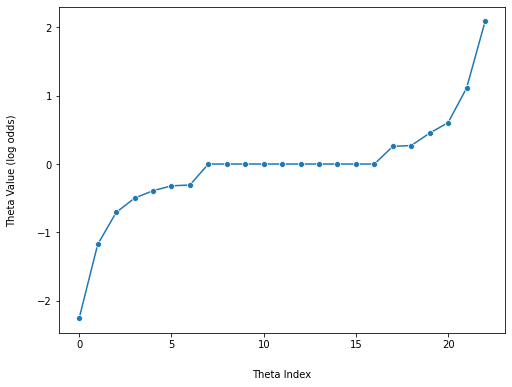

In [0]:
theta = np.sort(log_reg_model.coefficients)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=range(0,len(log_reg_model.coefficients)), y=theta, marker="o", axes=ax)
_ = ax.set_xlabel("Theta Index", labelpad=20)
_ = ax.set_ylabel("Theta Value (log odds)", labelpad=20)

In [0]:
# Collect training summary
training_summary = log_reg_model.summary

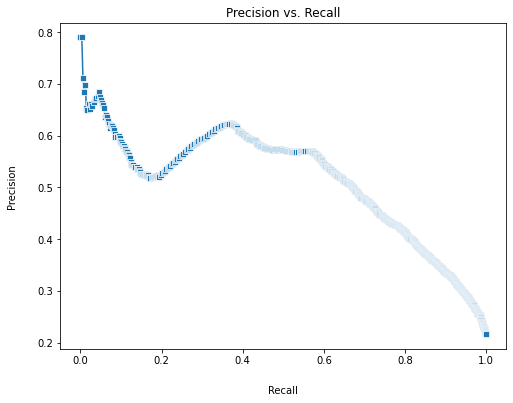

In [0]:
precision_recall = training_summary.pr.toPandas()

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=precision_recall['recall'], y=precision_recall['precision'], marker="s", axes=ax)
_ = ax.set_xlabel("Recall", labelpad=20)
_ = ax.set_ylabel("Precision", labelpad=20)
_ = ax.set_title("Precision vs. Recall")

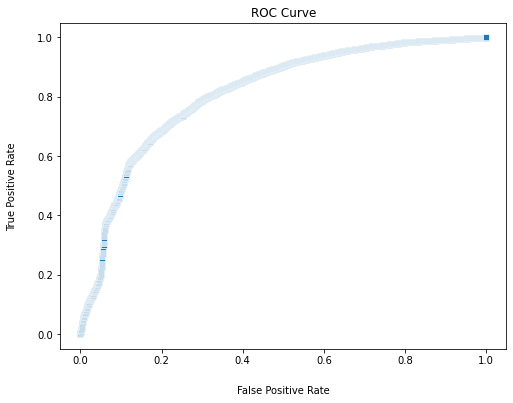

In [0]:
roc = training_summary.roc.toPandas()

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=roc['FPR'], y=roc['TPR'], marker="s", axes=ax)
_ = ax.set_xlabel("False Positive Rate", labelpad=20)
_ = ax.set_ylabel("True Positive Rate", labelpad=20)
_ = ax.set_title("ROC Curve")

In [0]:
# Print out the Area Under the ROC Curve (AUC)
print('Training Set AUC: {:.3f}'.format(training_summary.areaUnderROC))

Training Set AUC: 0.814

## Test Set

In [0]:
# Here, we use the same transformer as the one returned by the `to_numerical` function above yet applied to the test set
oh_test_df = oh_transformer.transform(test_df)

In [0]:
oh_test_df.show(5)

+------------+--------------+-------------+------------+--------------+----------+----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-------------------+----------------+----------------------------+-----------------------+-----------------------------+------------------------------------+-------------------------------+-------------------------------------+------------------------+---------------------------+-----+--------------------+
account_type|follower_count|friends_count|listed_count|statuses_count| retweets| with_url|with_mention|geo_enabled|verified|has_extended_profile|default_profile|default_profile_image|created_at|geo_enabled_indexed|verified_indexed|has_extended_profile_indexed|default_profile_indexed|default_profile_image_indexed|has_extended_profile_indexed_encoded|default_profile_indexed_encoded|default_profile_image_indexed_encoded|verified_indexed_encoded|geo_enabled_indexed_encoded|label| features|
+------------+--------------+-------------+------------+--------------+----------+----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-------------------+----------------+----------------------------+-----------------------+-----------------------------+------------------------------------+-------------------------------+-------------------------------------+------------------------+---------------------------+-----+--------------------+
 bot| 0| 0| 0| 104| 0.9879518| 0.3493976| 0.91566265| False| False| False| True| False| 3069| 1.0| 0.0| 0.0| 1.0| 0.0| (3,[0],[1.0])| (3,[1],[1.0])| (3,[0],[1.0])| (3,[0],[1.0])| (3,[1],[1.0])| 1.0|(23,[1,3,6,10,12,...|
 bot| 0| 12| 0| 456|0.33333334|0.33333334| 0.6666667| False| False| False| False| False| 3917| 1.0| 0.0| 0.0| 0.0| 0.0| (3,[0],[1.0])| (3,[0],[1.0])| (3,[0],[1.0])| (3,[0],[1.0])| (3,[1],[1.0])| 1.0|(23,[1,3,6,9,12,1...|
 bot| 1| 0| 0| 9|0.71428573|0.42857143| 0.71428573| False| False| False| True| False| 3382| 1.0| 0.0| 0.0| 1.0| 0.0| (3,[0],[1.0])| (3,[1],[1.0])| (3,[0],[1.0])| (3,[0],[1.0])| (3,[1],[1.0])| 1.0|(23,[1,3,6,10,12,...|
 bot| 1| 0| 0| 27| 0.6| 0.12| 0.6| False| False| False| True| False| 2309| 1.0| 0.0| 0.0| 1.0| 0.0| (3,[0],[1.0])| (3,[1],[1.0])| (3,[0],[1.0])| (3,[0],[1.0])| (3,[1],[1.0])| 1.0|(23,[1,3,6,10,12,...|
 bot| 2| 0| 0| 648| 0.0| 0.8923077| 0.0| False| False| False| True| True| 2126| 1.0| 0.0| 0.0| 1.0| 1.0| (3,[0],[1.0])| (3,[1],[1.0])| (3,[1],[1.0])| (3,[0],[1.0])| (3,[1],[1.0])| 1.0|(23,[1,3,6,10,13,...|
+------------+--------------+-------------+------------+--------------+----------+----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-------------------+----------------+----------------------------+-----------------------+-----------------------------+------------------------------------+-------------------------------+-------------------------------------+------------------------+---------------------------+-----+--------------------+
only showing top 5 rows

In [0]:
# Select `features` and `label` only
test = oh_test_df.select(["features", "label"])
test.show(5)


+--------------------+-----+
 features|label|
+--------------------+-----+
(23,[1,3,6,10,12,...| 1.0|
(23,[1,3,6,9,12,1...| 1.0|
(23,[1,3,6,10,12,...| 1.0|
(23,[1,3,6,10,12,...| 1.0|
(23,[1,3,6,10,13,...| 1.0|
+--------------------+-----+
only showing top 5 rows

In [0]:
predictions = log_reg_model.transform(test)

In [0]:
predictions.select("features", "prediction", "label").show(1000)


+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,13,...| 1.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[0,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,13,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,13,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[0,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[0,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,7,9,12,1...| 0.0| 1.0|
(23,[0,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[0,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[0,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,7,9,12,1...| 0.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 0.0| 1.0|
(23,[0,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[0,3,6,10,12,...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[0,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,7,10,12,...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[0,3,7,9,12,1...| 0.0| 1.0|
(23,[1,3,7,9,12,1...| 0.0| 1.0|
(23,[0,4,6,9,12,1...| 0.0| 1.0|
(23,[0,4,6,9,12,1...| 0.0| 1.0|
(23,[0,4,6,9,12,1...| 0.0| 1.0|
(23,[1,4,7,9,12,1...| 0.0| 1.0|
(23,[0,3,6,9,12,1...| 0.0| 1.0|
(23,[1,4,6,9,12,1...| 0.0| 1.0|
(23,[1,4,6,9,12,1...| 0.0| 1.0|
(23,[0,4,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,7,10,12,...| 0.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,10,12,...| 1.0| 0.0|
(23,[1,3,6,9,12,1...

In [0]:
evaluator = BinaryClassificationEvaluator()
print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(predictions)))

Test Set AUC: 0.820

## Tuning Hyperparameters

In [0]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train, 
                                 numerical_features, 
                                 categorical_features, 
                                 target_variable, 
                                 with_std=True,
                                 with_mean=True,
                                 k_fold=5):

    # Configure a logistic regression pipeline, which consists of the following stages: 
    # 1) convert categorical features to numerical ones
    # 2) standardize feature values (optional)
    # ... add any other custom transformation here ...
    # n) fit a logistic regression model


    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    # 2.a Create the StandardScaler
    # scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    # ...

    # 3 Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [encoder] + [label_indexer] + [assembler] # + [scaler] + ...

    # 4. Create the logistic regression transformer
    log_reg = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100) # change `featuresCol=std_features` if scaler is used
    # 5. Add the logistic regression transformer to the pipeline stages (i.e., the last one)
    stages += [log_reg]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for log_reg.regParam ($\lambda$) and 3 values for log_reg.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(log_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = logistic_regression_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

/databricks/spark/python/pyspark/ml/util.py:800: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [0]:
# Call the function above|
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #7 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #8 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #9 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

***************************************

*************** Fold #2 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #7 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #8 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #9 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

***************************************

*************** Fold #3 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; al

In [0]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.813
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.813
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.813
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.808
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.798
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.773
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.804
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.772
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.720

In [0]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getRegParam(), 
             cv_model.bestModel.stages[-1]._java_obj.getElasticNetParam(),
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: lambda=[0.000]; alfa=[0.000]
LogisticRegressionModel: uid=LogisticRegression_a4b19bcc6c28, numClasses=2, numFeatures=23

In [0]:
# `bestModel` is the best resulting model according to k-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1].summary
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result.areaUnderROC))
print("***** Training Set *****")

***** Training Set *****
Area Under ROC Curve (ROC AUC): 0.814
***** Training Set *****

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)

In [0]:
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,9,12,1...| 0.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,12,...| 1.0| 1.0|
(23,[1,3,6,10,13,...| 1.0| 1.0|
+--------------------+----------+-----+
only showing top 5 rows

In [0]:
def evaluate_model(predictions, metric="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(metricName=metric)
    return evaluator.evaluate(predictions)

In [0]:
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.820
Area Under Precision-Recall Curve: 0.541
***** Test Set *****

## Desicion Tree

In [0]:
# This function defines the general pipeline for logistic regression
def decision_tree_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):


    # Configure a decision tree pipeline, which consists of the following stages: 

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the decision tree transformer
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the decision tree transformer to the pipeline stages (i.e., the last one)
    stages += [dt]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for dt.maxDepth and 2 values for dt.impurity
    # this grid will have 3 x 2 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [3, 5, 8]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = decision_tree_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

In [0]:
# This function summarizes all the models trained during k-fold cross validation

def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDept=[{:d}]; impurity=[{:s}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getImpurity()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [0]:
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=3, numNodes=11, numClasses=2, numFeatures=13

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=3, numNodes=9, numClasses=2, numFeatures=13

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=5, numNodes=55, numClasses=2, numFeatures=13

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=5, numNodes=43, numClasses=2, numFeatures=13

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=8, numNodes=273, numClasses=2, numFeatures=13

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=8, numNodes=247, numClasses=2, numFeatures=13

***************************************

*************** Fold #2 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=3, numNodes=9, numClasses=2, numFeatures=13

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=3, numNodes=11, numClasses=2, numFeatures=13

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=5, numNodes=43, numClasses=2, numFeatures=13

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=5, numNodes=43, numClasses=2, numFeatures=13

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=8, numNodes=287, numClasses=2, numFeatures=13

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=8, numNodes=253, numClasses=2, numFeatures=13

***************************************

*************** Fold #3 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=3, numNodes=11, numClasses=2, numFeatures=13

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=3, numNodes=9, numClasses=2, numFeatures=13

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=5, numNodes=47, numClasses=2, numFeatures=13

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=5, numNodes=41, numClasses=2, numFeatures=13

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=8, numNodes=303, numClasses=2, numFeatures=13

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=8, numNodes=25

In [0]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.330
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.252
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.435
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.403
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.521
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.520

In [0]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]; impurity=[{:s}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             cv_model.bestModel.stages[-1]._java_obj.getImpurity(),
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: maxDept=[8]; impurity=[gini]
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5b926aad635e, depth=8, numNodes=323, numClasses=2, numFeatures=13

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(13,[0,3,8,9,10,1...| 1.0| 1.0|
(13,[0,6,8,9,10,1...| 0.0| 1.0|
[1.0,0.0,0.0,1.0,...| 1.0| 1.0|
[1.0,0.0,0.0,1.0,...| 1.0| 1.0|
(13,[0,3,4,5,8,10...| 1.0| 1.0|
+--------------------+----------+-----+
only showing top 5 rows

In [0]:
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.545
Area Under Precision-Recall Curve: 0.403
***** Test Set *****

## Random Forests

In [0]:
# This function defines the general pipeline for logistic regression
def random_forest_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):


    # Configure a random forest pipeline, which consists of the following stages: 

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the random forest transformer
    rf = RandomForestClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the random forest transformer to the pipeline stages (i.e., the last one)
    stages += [rf]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for rf.maxDepth and 3 values for rf.numTrees
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model


In [0]:
cv_model = random_forest_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             )
      )
print(cv_model.bestModel.stages[-1])

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.835
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.851
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.854
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.872
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.878
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.879
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.902
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.905
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.907
Best model according to k-fold cross validation: maxDept=[8]
RandomForestClassificationModel: uid=RandomForestClassifier_5e09bba329b2, numTrees=100, numClasses=2, numFeatures=13

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(13,[0,3,8,9,10,1...| 1.0| 1.0|
(13,[0,6,8,9,10,1...| 0.0| 1.0|
[1.0,0.0,0.0,1.0,...| 1.0| 1.0|
[1.0,0.0,0.0,1.0,...| 1.0| 1.0|
(13,[0,3,4,5,8,10...| 1.0| 1.0|
+--------------------+----------+-----+
only showing top 5 rows

In [0]:
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.914
Area Under Precision-Recall Curve: 0.821
***** Test Set *****

## Gradient Boosted Decision Tree

In [0]:
# This function defines the general pipeline for logistic regression
def gbdt_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):

    # Configure a gradient boosted decision tree pipeline, which consists of the following stages: 

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the gradient boosted decision tree transformer
    gbdt = GBTClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the gradient boosted decision tree transformer to the pipeline stages (i.e., the last one)
    stages += [gbdt]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for gbdt.maxDepth and 3 values for gbdt.maxIter (i.e., boosting rounds)
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(gbdt.maxDepth, [3, 5, 8]) \
    .addGrid(gbdt.maxIter, [10, 50, 100]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = gbdt_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
print("Best model according to k-fold cross validation: maxDept=[{:d}]; maxIter=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             cv_model.bestModel.stages[-1]._java_obj.getMaxIter()
             )
      )
print(cv_model.bestModel.stages[-1])

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

In [0]:
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

## Logistic Regression on textual features

In [0]:
def ml_pipeline(train):
    
    print("***** Defining the pipeline stages *****\n")
    
    # define stage 1: tokenize the tweet text  
    stage_1 = RegexTokenizer(inputCol="tweet", outputCol="tokens", pattern="\\W")
    # define stage 2: remove the stop words
    stage_2 = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
    # define stage 3: create a word vector of the size 100
    stage_3 = Word2Vec(inputCol="filtered_words", outputCol="feature_vector", vectorSize=100)
    # define stage 4: Logistic Regression Model
    model = LogisticRegression(featuresCol="feature_vector", labelCol="label") 
    
    print("***** Create the corresponding pipeline *****\n")
    pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, model])

    print("***** Fit the pipeline to the training data *****\n")
    pipeline_fit = pipeline.fit(train)
    
    return pipeline_fit
  
# Define the function to get the predicted sentiment on the data received
def get_prediction(pipeline_fit, tweet_text):
    try:
        # remove blank tweets
        tweet_text = tweet_text.filter(lambda x: len(x) > 0)
        # create the dataframe with each row containing the text of a tweet
        row_rdd = tweet_text.map(lambda w: Row(tweet=w))
        words_df = spark.createDataFrame(row_rdd)
        # get the prediction for each row
        pipeline_fit.transform(words_df).select("tweet", "prediction").show(truncate=False)
    except: 
        print("\nWaiting for streaming data...\n")

In [0]:
tweet_train_df, tweet_test_df = bot_df_text.randomSplit([0.8, 0.2], seed=RANDOM_SEED)
tweet_train_df = tweet_train_df.na.drop()
# Fit the ML pipeline to the training set of tweets
pipeline_fit = ml_pipeline(tweet_train_df)